In [1]:
import pandas as pd
import numpy as np
from auto_segment_FEMPT import BasicSegmenterEG_FEMPT
# reload(auto_segment_FEMPT.BasicSegmenterEG_FEMPT)
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
boston = load_boston()
#print(boston.data.shape)

In [2]:
base_address = "./Notebooks/Datasets/"
dataSets = []
dataSets_temp = []
data_names = ['servo','abalone','ozone']
for i in range(0,len(data_names)):
    dataSets_temp.append(pd.read_csv(base_address+data_names[i]+'.csv'))
    temp_data = pd.read_csv(base_address+data_names[i]+'.csv')
    temp_data = pd.get_dummies(temp_data)
    temp_output = pd.DataFrame(temp_data['output'])
    temp_data.drop('output',axis=1,inplace=True)
    temp_data = pd.concat([temp_data, temp_output], axis=1)
    dataSets.append(temp_data)
# Boston Data
b_feat = pd.DataFrame(boston.data)
b_feat.columns = ['feat_0','feat_1','feat_2','feat_3','feat_4','feat_5','feat_6','feat_7','feat_8','feat_9','feat_10','feat_11','feat_12']
b_target = pd.DataFrame(boston.target)
b_target.columns = ['output']
b_data = pd.concat([b_feat,b_target],axis=1)
dataSets.append(b_data)

In [3]:
def get_result(model_,data_, frac):
    model = clone(model_)
    output = data_['output']
    data_.drop('output',axis=1,inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(data_, output, test_size=frac)
    model.fit(X_train,y_train)
    test_result = model.predict(X_test)
    return mean_squared_error(y_test,test_result), test_result, model

In [4]:
def get_result_iter(data, N_iterations, frac, models):
    #get_result(FS,temp_data)
    model_list = []
    Result_mses = []
    temp_model_perf = []
    for i in range(0,len(models)):
        model_iter_results = []
        for j in range(0,N_iterations):
            temp_data = data.copy(deep=True)
            temp_rs, temp_pred, model = get_result(models[i],temp_data, frac)
            #print model.best_params_
            model_iter_results.append(temp_rs)
            model_list.append(model)
        temp_model_perf.append(model_iter_results)
        Result_mses.append(sum(model_iter_results)/len(model_iter_results))
    return Result_mses, model_list, temp_model_perf

In [5]:
Res_all_ds = []
model_f = []
perf_f = []
for i in range(0,len(dataSets)):
    t_data = dataSets[i].copy(deep=True)
    N_iterations = 10
    g_frac = 0.10
    # Parameters I want to sweep on.
    parameters = {
        'n_votes': [1,3,5,10],
        'init_sample_percentage':[0.2,0.5,1]
    }
    # Default params
    FEMPT = BasicSegmenterEG_FEMPT(**{'cxpb': 0.5,
 'indpb': 0.2,
 'init_sample_percentage': 0.2,
 'mutpb': 0.5,
 'n': 10,
 'n_population': 20,
 'ngen': 10,
 'statistics': False,
#  'test_size': 0.25,
 'tournsize': 3,
 'base_estimator': DecisionTreeRegressor(max_depth=5),
 'n_votes' : 3
})
    
    #grid_model = RandomizedSearchCV(FS, parameters, verbose=True, scoring="mean_squared_error",n_iter=100)
#     grid_model = GridSearchCV(FEMPO, parameters, verbose=True, scoring="mean_squared_error", cv = 3, n_jobs= 1 )
    grid_model = FEMPT
    g_models = []
    g_models.append(grid_model)
#     g_models.append(Ba)
    g_models.append(BaggingRegressor(max_samples=0.99, bootstrap = True, oob_score = True, 
                                                  base_estimator = DecisionTreeRegressor(max_depth = 5),
                                                 n_estimators = 10))
    Result_t, model_list, model_perf = get_result_iter(t_data, N_iterations, g_frac, g_models)
    Res_all_ds.append(Result_t)
    model_f.append(model_list)
    perf_f.append(model_perf)
dataSet_names = ['Servo','Abalone','Ozone','Boston-housing']
model_names = ['FEMPT', 'BaggingRegressor']
Result_test_bench = pd.DataFrame(Res_all_ds)
Result_test_bench.columns = model_names
Result_test_bench.set_index([dataSet_names],inplace=True)
Result_test_bench

TypeError: Invalid parameters passed: {'stratify': array([ 0.8062546 ,  0.69375384,  0.9562557 ,  0.5437528 ,  0.88125515,
        0.35625148,  0.5437528 ,  0.9187554 ,  0.8062546 ,  0.28125095,
        5.7000422 ,  0.69375384,  0.5062525 ,  0.88125515,  0.9187554 ,
        0.7312541 ,  0.31875122,  0.99375594,  1.0312537 ,  1.4999949 ,
        1.2999974 ,  3.899964  ,  7.1001077 ,  0.88125515,  4.299977  ,
        0.20625044,  0.39375174,  0.9187554 ,  0.46875226,  1.8999897 ])}

In [ ]:
Result_test_bench

In [28]:
for m in model_f:
    print m[0].best_params_
#     print m

{'n_votes': 10, 'init_sample_percentage': 0.5}
{'n_votes': 10, 'init_sample_percentage': 0.5}
{'n_votes': 10, 'init_sample_percentage': 0.5}
{'n_votes': 5, 'init_sample_percentage': 1}


[GridSearchCV(cv=3, error_score='raise',
        estimator=BasicSegmenterEG_FEMPO(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
             crossover_func=<function cxTwoPoint at 0x107C1DF0>, cxpb=0.5,
             indpb=0.2, init_sample_percentage=0.2, mutpb=0.5, n=10,
             n_population=20, n_votes=1, ngen=10, statistics=False,
             test_size=0.2, tournsize=3),
        fit_params={}, iid=True, loss_func=None, n_jobs=1,
        param_grid={'n_votes': [1, 3, 5, 10], 'init_sample_percentage': [0.2, 0.5, 1]},
        pre_dispatch='2*n_jobs', refit=True, score_func=None,
        scoring='mean_squared_error', verbose=True)]

In [16]:
p= pd.DataFrame(perf_f)

In [16]:
model_perf

[11.819631267188088, 15.347409004815104]

(array([ 2.,  1.,  1.,  1.,  2.,  0.,  0.,  2.,  0.,  1.]),
 array([ 0.00886955,  0.02995639,  0.05104323,  0.07213007,  0.09321691,
         0.11430375,  0.1353906 ,  0.15647744,  0.17756428,  0.19865112,
         0.21973796]),
 <a list of 10 Patch objects>)

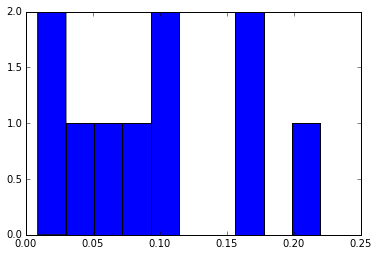

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(p.iloc[0][1])

(array([ 6.,  8.,  5.,  2.,  2.,  1.,  1.,  2.,  2.,  1.]),
 array([  5.15293162,   7.55897823,   9.96502485,  12.37107146,
         14.77711808,  17.18316469,  19.5892113 ,  21.99525792,
         24.40130453,  26.80735115,  29.21339776]),
 <a list of 10 Patch objects>)

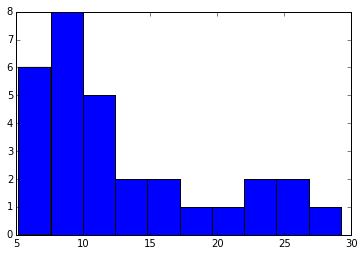

In [35]:
plt.hist(p.iloc[3][1])

In [6]:
import sklearn

In [7]:
sklearn.__version__

'0.16.1'